In [ ]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
odf = pd.read_csv('sample_data/ETTh1.csv')
odf['date'] = pd.to_datetime(odf['date'])
print(odf.head())

                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [ ]:
odf['OT_diff'] = odf['OT'].diff()
odf = odf.dropna(subset=['OT_diff']).reset_index(drop=True)
odf = odf.drop(columns=['OT', 'date'])

In [ ]:
samples_per_day = 24
train_days = 12 * 30
val_days = 6 * 30
sequence_length = 48
forecast_horizon = 96

train_size = train_days * samples_per_day
val_size = val_days * samples_per_day

train_mean = odf[:train_size].mean(axis=0)
train_std = odf[:train_size].std(axis=0)
odf = (odf - train_mean) / train_std

train_data = odf[:train_size]
val_data = odf[train_size:train_size + val_size]
test_data = odf[train_size + val_size:]



In [ ]:
delay = sequence_length + forecast_horizon - 1

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data[:-delay],
    targets=train_data['OT_diff'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(train_size, len(train_data) - delay - 1)
)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=val_data[:-delay],
    targets=val_data['OT_diff'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(val_size, len(val_data) - delay - 1)
)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=test_data[:-delay],
    targets=test_data['OT_diff'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(len(test_data) - delay - 1, len(test_data))
)


In [ ]:
def unnormalize(preds, targets, mean, std):
    preds = preds * std + mean
    targets = targets * std + mean
    return preds, targets

def evaluate_model(dataset, model=None):
    total_abs_err = 0.0
    num_sequences = 0
    temp_index = 6

    for samples, targets in dataset:
        if model is None:
            preds = samples[:, -1, temp_index]
        else:
            preds = model.predict(samples, verbose=0).flatten()

        preds, targets = unnormalize(preds, targets, train_mean.iloc[temp_index], train_std.iloc[temp_index])
        total_abs_err += np.sum(np.abs(preds - targets))
        num_sequences += samples.shape[0]

    return total_abs_err / num_sequences

baseline_mae = evaluate_model(val_dataset)
print(f"Validation MAE Baseline: {baseline_mae:.2f}")


Validation MAE Baseline: 0.74


In [ ]:
num_features = odf.shape[-1]

def build_lstm(sequence_length, num_features):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    lstm_model = keras.Model(inputs, outputs)
    return lstm_model

lstm_model = build_lstm(sequence_length=sequence_length, num_features=num_features)

checkpoint = keras.callbacks.ModelCheckpoint("best_lstm_model.keras", save_best_only=True)
rop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),loss="mse", metrics=["mae"])

history = lstm_model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[checkpoint, early_stopping, rop])


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 1.0917 - mae: 0.7243 - val_loss: 0.5822 - val_mae: 0.5009 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 1.0722 - mae: 0.7105 - val_loss: 0.5805 - val_mae: 0.4992 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.0766 - mae: 0.7124 - val_loss: 0.5793 - val_mae: 0.4983 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.0732 - mae: 0.7111 - val_loss: 0.5782 - val_mae: 0.4976 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.0693 - mae: 0.7111 - val_loss: 0.5773 - val_mae: 0.4970 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.0728 - mae: 0.7101 - val_loss: 0.5766 - val_mae: 0.4965 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.0690 - mae: 0.7093 - val_loss: 0.5757 - val_mae: 0.4959 - learning_ra

In [ ]:
print(lstm_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 48, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,645 (361.90 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,764 (241.27 KB)

None


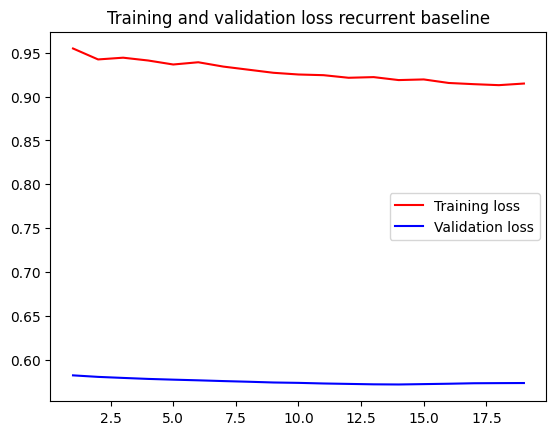

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()

The graph shows the model's training loss decreases, but the validation loss stays mostly flat, indicating potential overfitting

In [ ]:
lstm_model = keras.models.load_model("best_lstm_model.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=lstm_model):.2f}")


Validation MAE lstm: 0.53


In [ ]:
def build_stacked_lstm(sequence_length, num_features, learning_rate):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.GRU(64, return_sequences=True)(inputs)
    x = layers.GRU(32)(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
best_learning_rate = 0.0001
num_features = odf.shape[-1]
lstm_model1 = build_stacked_lstm(sequence_length=sequence_length, num_features=num_features, learning_rate=best_learning_rate)

checkpoint = keras.callbacks.ModelCheckpoint("best_lstm_model1.keras", save_best_only=True)
rop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

lstm_model1.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=best_learning_rate, weight_decay=1e-5),loss="mse", metrics=["mae"])

history = lstm_model1.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[checkpoint, early_stopping, rop])


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.5731 - mae: 0.9317 - val_loss: 0.7343 - val_mae: 0.6028 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.2921 - mae: 0.8194 - val_loss: 0.6310 - val_mae: 0.5372 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.1813 - mae: 0.7695 - val_loss: 0.5963 - val_mae: 0.5119 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.1440 - mae: 0.7519 - val_loss: 0.5857 - val_mae: 0.5040 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.1220 - mae: 0.7400 - val_loss: 0.5814 - val_mae: 0.5011 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.1214 - mae: 0.7396 - val_loss: 0.5798 - val_mae: 0.5002 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.1063 - mae: 0.7308 - val_loss: 0.5792 - val_mae: 0.4999 - learning_ra

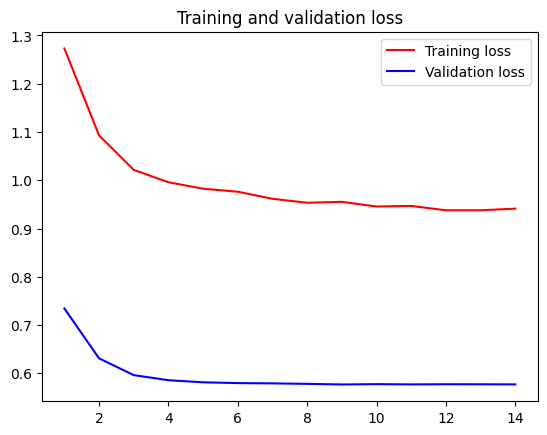

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training loss decreases steadily, but validation loss stops improving, suggesting overfitting

In [ ]:
lstm_model = keras.models.load_model("best_lstm_model1.keras")
print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=lstm_model1):.2f}")

Validation MAE lstm: 0.53


Tuned the sequence length in the range (48, 96, 120, 336). Out of all, sequence length 48 gave the best MAE of 0.53. Where as seq_len 336 has given MAE of 0.55,whereas both sequence length of 96 and 120 gave mae of 0.54

In [ ]:
def build_1dconv(sequence_length, num_features):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.Conv1D(8, 24, activation="relu",padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 12, activation="relu",padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 8, activation="relu",padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

conv1D_model = build_1dconv(sequence_length, num_features)
conv1D_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 48, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 48, 8)               │           1,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 24, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 24, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 12, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 12, 8)               │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,657 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("temp_conv1d.keras",save_best_only=True)
conv1D_model.compile(optimizer="adamW", loss="mse", metrics=["mae"])
history = conv1D_model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=[checkpoint, rop])

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 1.0919 - mae: 0.7209 - val_loss: 0.5920 - val_mae: 0.5088 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.0754 - mae: 0.7140 - val_loss: 0.5882 - val_mae: 0.5053 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.0681 - mae: 0.7078 - val_loss: 0.5833 - val_mae: 0.5028 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0632 - mae: 0.7079 - val_loss: 0.5778 - val_mae: 0.5009 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.0556 - mae: 0.7027 - val_loss: 0.5862 - val_mae: 0.5104 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0453 - mae: 0.6986 - val_loss: 0.5842 - val_mae: 0.5105 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.0345 - mae: 0.6951 - val_loss: 0.5928 - val_mae: 0.5185 - learning_rate: 0.0010
Epoch 8/50
34

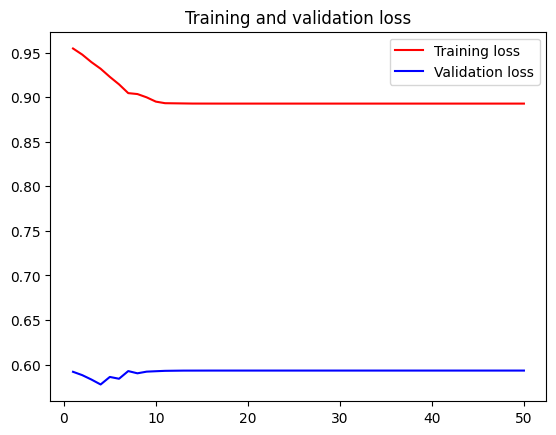

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training loss improves, but validation loss stays flat.

In [ ]:
conv1D_model = keras.models.load_model("temp_conv1d.keras")
print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=conv1D_model):.2f}")

Validation MAE lstm: 0.54


Tuned the Kernelsize between [24,12,8] [12,8,6],[8,6,4]. Kernel size of [24,12,8] has given the best MAE and all the models outperform the baseline model

In [ ]:
best_model=keras.models.load_model("best_lstm_model1.keras")
test_mae_best_model = evaluate_model(test_dataset, model=best_model)
test_mae_commonsense_model = evaluate_model(test_dataset)

print(f"Test MAE for best model: {test_mae_best_model:.2f}")
print(f"Test MAE for commonsense model: {test_mae_commonsense_model:.2f}")

Test MAE for best model: 0.46
Test MAE for commonsense model: 0.62


our best model beats the common sense model

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


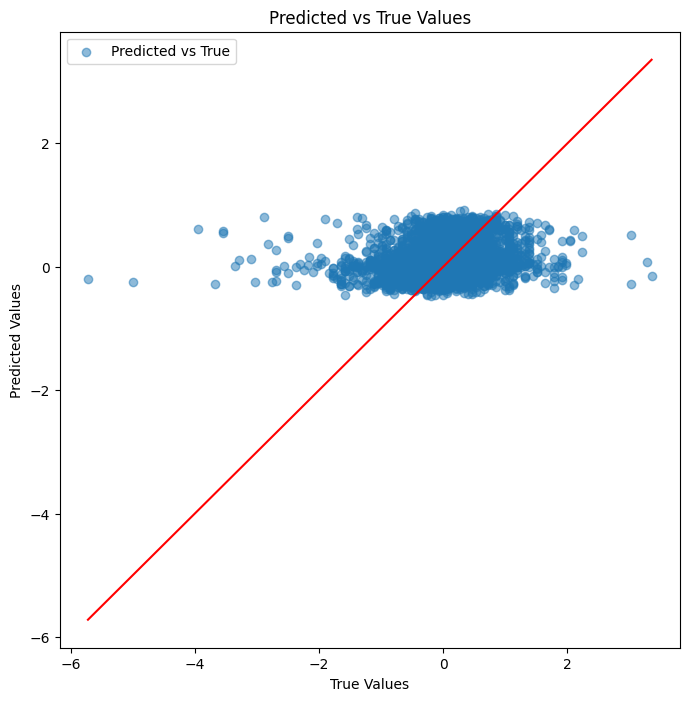

In [ ]:
true_values = [y for x, y in test_dataset]
true_values = np.concatenate(true_values, axis=0)

predicted_values = best_model.predict(test_dataset)
predicted_values = predicted_values.flatten()
plt.figure(figsize=(8, 8))
plt.scatter(true_values, predicted_values, alpha=0.5, label="Predicted vs True")
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()],
         color='red')

plt.title("Predicted vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()